# Data Extraction and Detecting Time Series Components

First thing first, let me import the Python libraries first.

In [21]:
import json

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from io import StringIO
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# add ../src to sys.path
import sys
sys.path.append('..')

from FiDaL.data import make_data
from FiDaL import optimization as optz
from FiDaL.plot import plot_adj_close_volume, plot_moving_average, plot_autocorrelation, plot_partial_autocorrelation


import warnings
# warnings.filterwarnings('ignore')

In [2]:
# Read the credentials from credentials.json
with open('../config/credentials.json') as f:
    credentials = json.load(f)
    
    # Read the config from config.json
with open('../config/config.json') as f:
    config = json.load(f)

For the sake of practice, let me work with telecom industry and to do that I pick `AT&T` (T) and `Verizon` (VZ). As a stock price I choose closing price, which is more stable and informative compared to high, low, open. Adjusted closing price would be an another good choice. 

The period that I cover is 01/01/2020-06/01/2021 and the stock price data is daily, meaning that we have 253 observations. 

### Download and load the data

Selecting the right data period is crucial for the analysis. The following factors should be considered when selecting the data period:
- **Market changes**: Financial markets undergo structural changes over time. Regulations, economic conditions, technological advancements, and other factors can alter market dynamics. It's crucial to ensure that the data used is still representative of current conditions.
- **More Recent Data**: Some analysts prefer using more recent data (e.g., 3-5 years) on the premise that it better reflects the current market dynamics. Financial markets evolve, and the factors that influenced stock performance a decade ago may not be as relevant today.
- **Specific Asset Characteristics**: Different assets may require different look-back periods based on their volatility, liquidity, and the sectors they represent. For instance, technology stocks may behave differently compared to utility stocks over the same period.
- **Investment Horizon**: Align the data period with your investment horizon. If you are a long-term investor, using a longer historical period may be more appropriate. For shorter-term investments, consider using a shorter data period.
- **Statistical Significance:** Ensure that the data set is large enough to be statistically significant, reducing the risk of anomalies skewing the results.
- Be aware of **regime changes** (significant shifts in market trends or economic conditions) within your data period. These can significantly impact the relevance of historical data.
- **Consider using rolling windows** for your analysis. This technique involves continuously updating the time frame of the data used for the analysis (e.g., always using the most recent five years of data). This can provide a more dynamic view of how optimal weights change over time.

In [3]:
# Create an instance of the YFDataDownloader class
downloader = make_data.YFDataDownloader(config, credentials=credentials)

# Get the data for ticker AT&T (T), Verizon (VZ), and the S&P 500 (SPY) using downloader.get_data()
print(config["data_source_params"])
data = downloader.get_data(**config["data_source_params"])
# transform data to a xarray dataset
# data = data.to_xarray()

{'tickers': ['T', 'VZ'], 'start_date': '2021-01-01', 'end_date': '2024-12-31', 'interval': '1d'}


### Data Exploration

In [4]:
data.describe()[('Adj Close')]

,T,VZ
count,737.000000,737.000000
mean,16.977568,41.930676
std,1.516284,6.236025
min,13.197869,30.670000
25%,15.826833,35.714676
50%,17.326967,44.369167
75%,18.099558,47.653427
max,20.451708,51.375645


**AT&T (T)**:

- **Count**: 737 observations.
- **Mean Price**: Approximately $16.977.
- **Standard Deviation**: About $1.516, indicating moderate price volatility.
- **Minimum Price**: Around $13.198
- **Maximum Price**: Approximately $20.451.

**Verizon (VZ)**:

- **Count**: 737 observations.
- **Mean Price**: Approximately $41.931.
- **Standard Deviation**: About $6.236, suggesting higher price volatility compared to AT&T.
- **Minimum Price**: Around $30.670.
- **Maximum Price**: Approximately $51.376

In [6]:
ticker_A, ticker_B = config["data_source_params"]["tickers"]

adj_close_A = data[('Adj Close', ticker_A)]
adj_close_B = data[('Adj Close', ticker_B)]

# Calculate daily returns
returns_A = adj_close_A.pct_change().dropna()
returns_B = adj_close_B.pct_change().dropna()

### Data Preprocessing
Considerations for data preprocessing include:
- **Missing Data**: Missing data can be problematic for time series analysis. If the data is missing at random, it may be possible to fill in the missing values using interpolation or other techniques. If the data is missing systematically, it may be necessary to exclude the data or adjust the analysis to account for the missing data.
- **Outliers**: Outliers can skew the results of the analysis. It's important to identify and remove outliers before conducting the analysis.
- **Data Scaling**: Some time series analysis techniques require the data to be scaled. For instance, the data may need to be scaled to have a mean of zero and a standard deviation of one.
- **Data Normalization**: Some time series analysis techniques require the data to be normalized. For instance, the data may need to be normalized to a range of 0 to 1.
- **Data Smoothing**: Some time series analysis techniques require the data to be smoothed. For instance, the data may need to be smoothed using a moving average.
- **Data Stationarity**: Some time series analysis techniques require the data to be stationary. For instance, the data may need to be stationary to use an ARIMA model.
- **Data Decomposition**: Some time series analysis techniques require the data to be decomposed into trend, seasonal, and residual components. For instance, the data may need to be decomposed to use an additive model.
- **Data Transformation**: Some time series analysis techniques require the data to be transformed. For instance, the data may need to be transformed to use a log-normal distribution.
- **Data Differencing**: Some time series analysis techniques require the data to be differenced. For instance, the data may need to be differenced to use an ARIMA model.
- **Data Aggregation**: Some time series analysis techniques require the data to be aggregated. For instance, the data may need to be aggregated to use a monthly time frame.
- **Data Resampling**: Some time series analysis techniques require the data to be resampled. For instance, the data may need to be resampled to use a monthly time frame.
- **Data Splitting**: Some time series analysis techniques require the data to be split into training and test sets. For instance, the data may need to be split to use a holdout set.
- **Data Shifting**: Some time series analysis techniques require the data to be shifted. For instance, the data may need to be shifted to use a lagged time frame.
- **Data Alignment**: Some time series analysis techniques require the data to be aligned. For instance, the data may need to be aligned to use a lagged time frame.
- **Data Normalization**: Some time series analysis techniques require the data to be normalized. For instance, the data may need to be normalized to a range of 0 to 1.
- **Data Interpolation**: Some time series analysis techniques require the data to be interpolated. For instance, the data may need to be interpolated to fill in missing values.
- **Data Imputation**: Some time series analysis techniques require the data to be imputed. For instance, the data may need to be imputed to fill in missing values.
- **Data Encoding**: Some time series analysis techniques require the data to be encoded. For instance, the data may need to be encoded to use a categorical variable.

### Visual analzysis

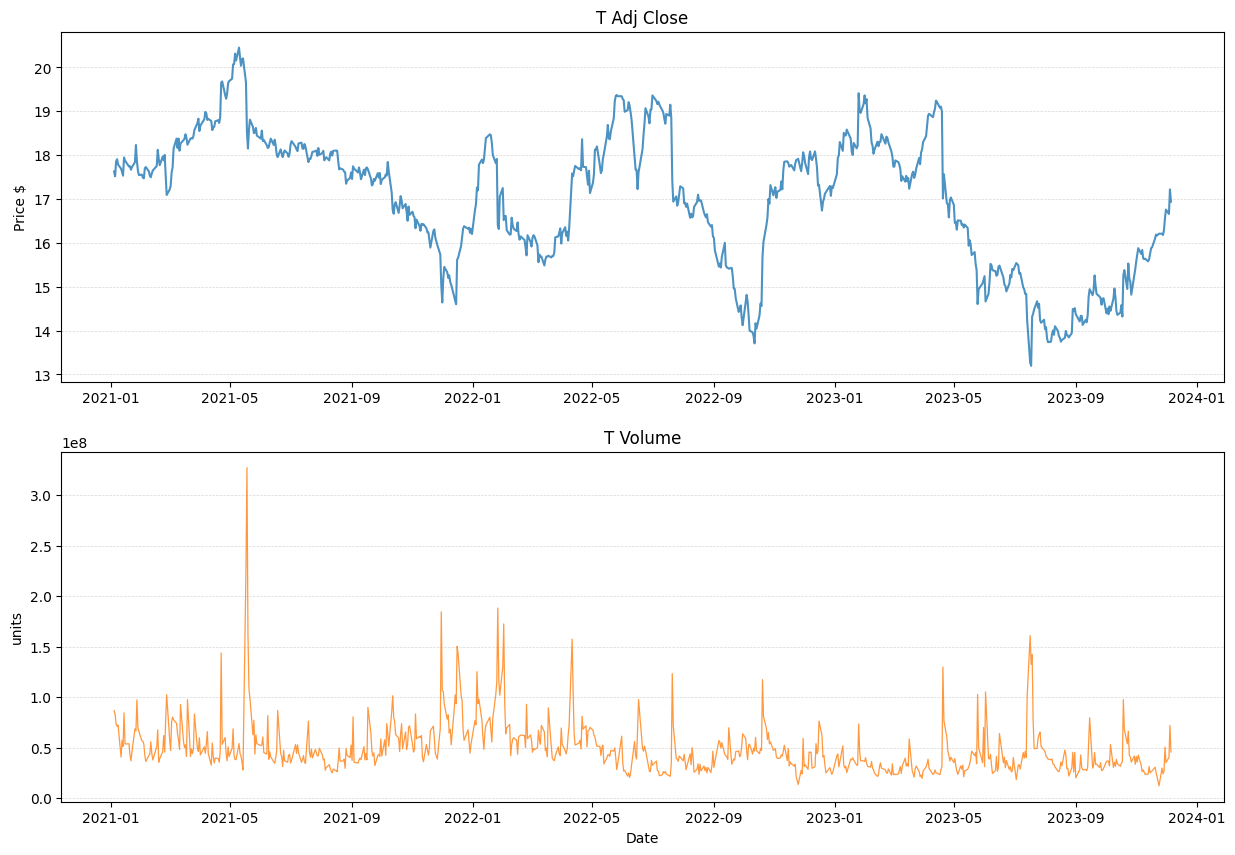

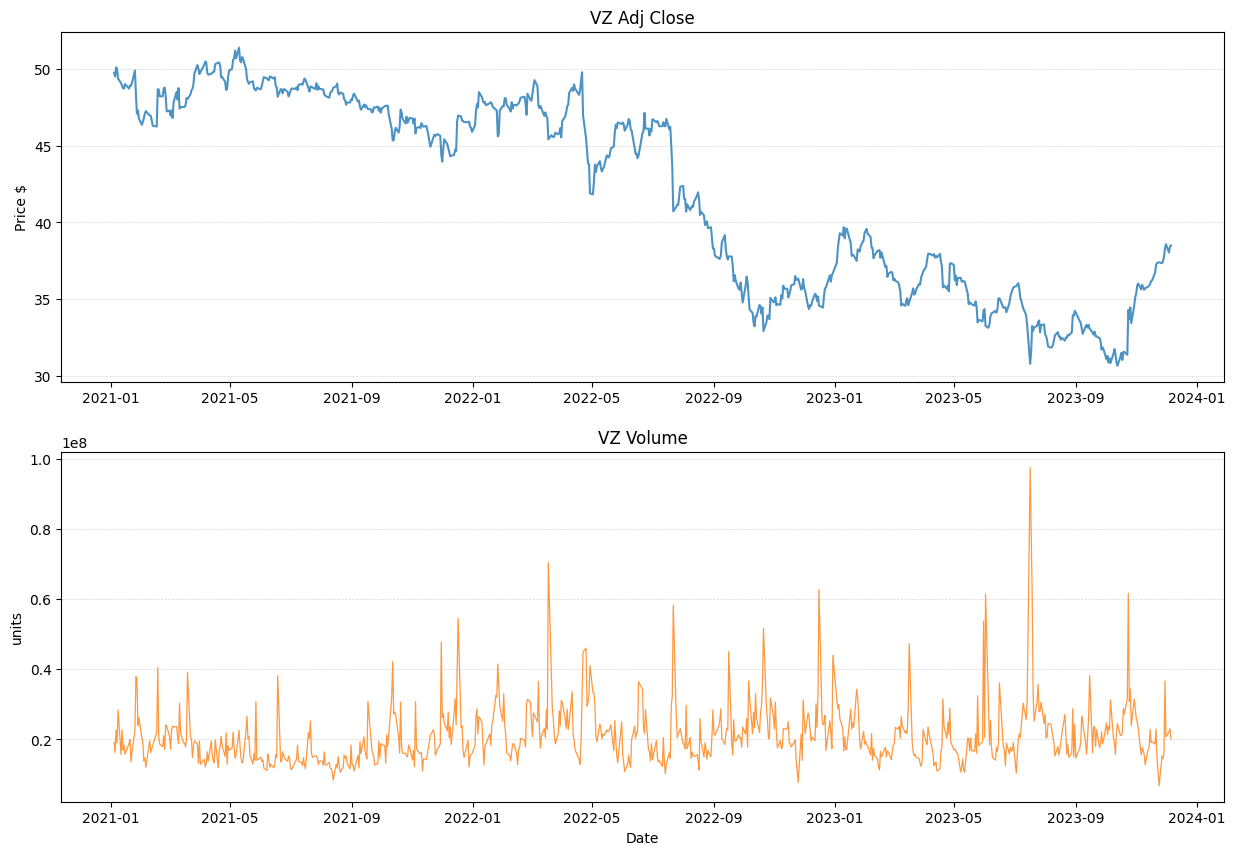

In [7]:
plot_adj_close_volume(data, ticker=ticker_A, y_log=False)
plot_adj_close_volume(data, ticker=ticker_B, y_log=False)

> Comments for Feb 2014
<!-- This spike is correct:

* On February 24, 2014, [Vodafone Group Plc (LSE:VOD) spun off a 30% stake in Verizon Communications Inc. (NYSE:VZ) for $59.3 billion.](https://www.marketscreener.com/quote/stock/VODAFONE-GROUP-PLC-15867071/news/Vodafone-Group-Plc-completed-the-spin-off-of-30-stake-in-Verizon-Communications-Inc-NYSE-VZ-for-38808632/#:~:text=Vodafone%20Group%20Plc%20(LSE:VOD)%20completed%20the%20spin%2D,and%20$23.9%20billion%20of%20cash.). Vodafone shareholders received all of the Verizon shares and $23.9 billion in cash.

* Vodafone also consolidated its ordinary shares on February 24, 2014. The consolidation was intended to keep Vodafone's share price relatively unchanged.[[1](https://www.bloomberg.com/news/articles/2014-02-21/verizon-stake-sale-cuts-vodafone-s-value-by-half-to-100-billion#:~:text=The%20stock%20consolidation%2C%20in%20a%20bid%20to,changed%2C%20also%20happens%20on%20the%20Feb.%2024.)][[2](https://investors.vodafone.com/sites/vodafone-ir/files/verizon-wireless-transaction/tax-information-on-the-return-of-value.pdf#:~:text=Following%20the%20Return%20of%20Value%2C%20Vodafone%20consolidated,new%20ordinary%20shares%20for%20every%2011%20existing)]

* Verizon became the sole owner of its wireless business in 2014 when it bought Vodafone's 45% stake. Vodafone received $58.9 billion in cash, $60.2 billion in stock, and $11 billion in other consideration.[[3](https://en.wikipedia.org/wiki/Verizon_(mobile_network)#:~:text=Majority%20owner%20Verizon%20Communications%20became,$11%20billion%20in%20other%20consideration.)]

* Verizon shares admitted to listing on London Stock Exchange [[4](https://www.reuters.com/article/verizoncommunications-brief-idINWLB007BD20140224/)] -->

### Moving Average

#### AT&T

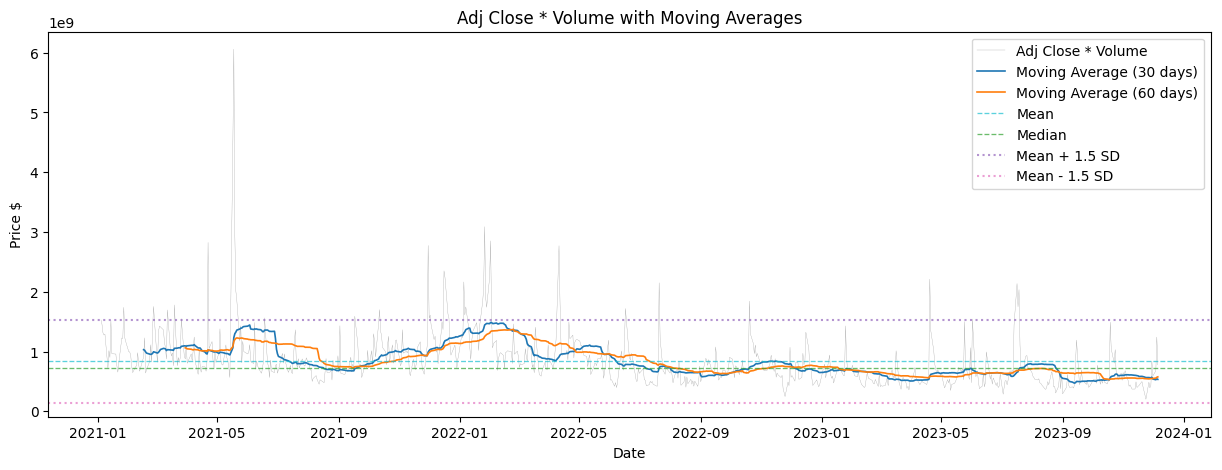

In [8]:
plot_moving_average(adj_close:=data[('Adj Close', ticker_A)],
                    volume:=data[('Volume', ticker_A)],
                    window_sizes=[30, 60], include_stats=True, log_scale=False)

#### Verizon

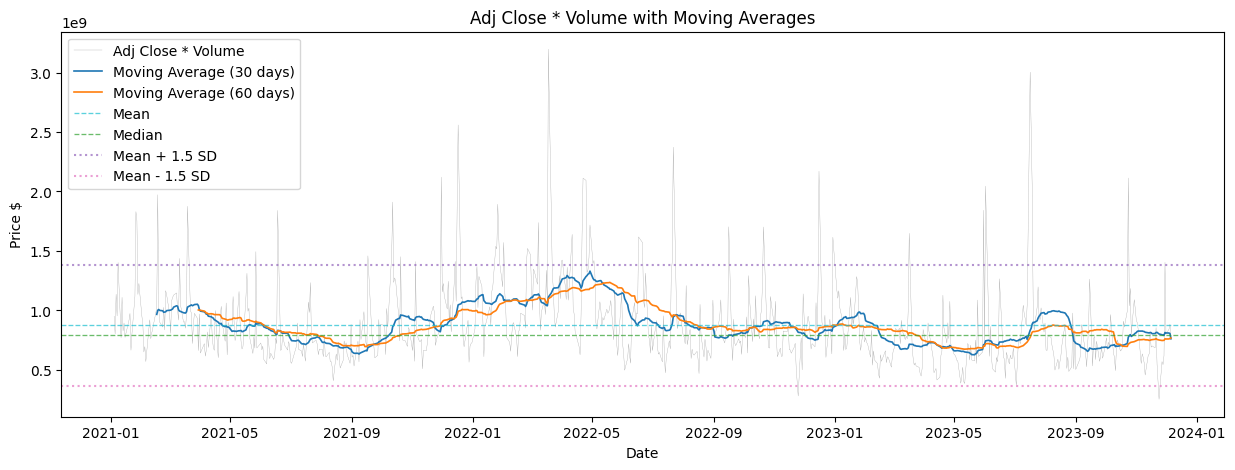

In [9]:
plot_moving_average(adj_close:=data[('Adj Close', ticker_B)],
                    volume:=data[('Volume', ticker_B)],
                    window_sizes=[30, 60], include_stats=True, log_scale=False)

### Seasonal decomposition

#### AT&T

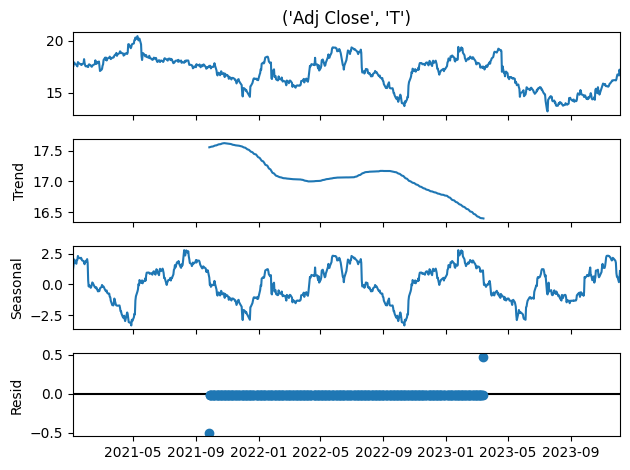

In [10]:
seasonal_decompose(
    adj_close_A, model='additive', period=len(data) // 2
).plot()
plt.show()


#### Verizon

There are some striking observation that I can get from this plot. One of them is the sudden drop occured in the mid of 2020. This corresponds to Covid-19 pandemic and therefore it makes sense to say that pandemic badly affected the stock prices in telecom industry as well as others. The other important observation is that stock price of Verizon exhibits a clear upward movement. However, even though a modest upward trend is visible during pre-Covid-19 era for AT&T, the stock price of this company has not revert back to its previous level.

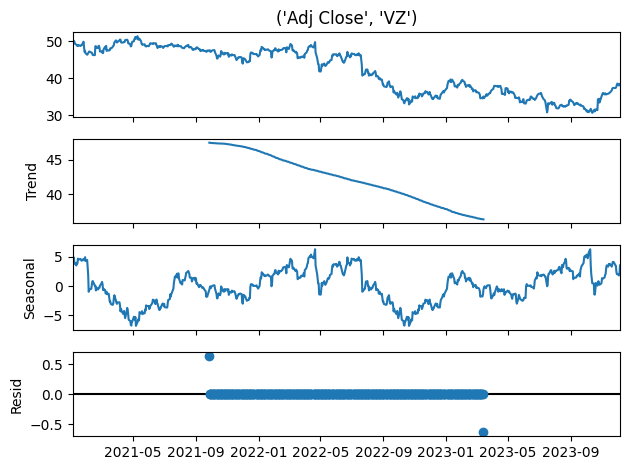

In [11]:
seasonal_decompose(
    adj_close_B, model='additive', period=len(data) // 2
).plot()
plt.show()

Well, now we have three components of the time series. The first plot represents the behavior of raw data and the rest three plots exhibits the trend, seasonality, and residuals.

Let me briefly discuss the additive model with a period of 360. In time series, multiplicative model works well if the amplitude of both the seasonal and irregular variations increase as the level of the trend rises. Alternatively, additive model is suitable when the amplitude of both the seasonal and irregular variations do not change as the level of the trend rises or falls.

In `seasonal_decompose` library, we need to identify the period as long as we do not have timeseries index. Given the period of the data, the parameter period changes. For instance, if the data period is daily, then period becomes 360 and if the data period is monthly, the period takes the value of 12.

### Autocorrelation, and Partial-Autocorrelation

The correlation in daily returns would indicate how consistent the price movements are.

##### Autocorrelation
The autocorrelation function (ACF) measures how the stock's price is related to its past values.

Interpretation of the autocorrelation plot is as follows:
- If the autocorrelation value is close to 1 or -1, it indicates a strong correlation. Positive or negative values indicate a positive or negative correlation, respectively. 
- If the autocorrelation value is close to 0, it indicates a weak or no correlation.


##### Partial autocorrelation
The partial autocorrelation function (PACF) gives a clearer picture of the relationship between a time series and its lags by removing the effects of earlier lags. This makes it a valuable tool in identifying the order of autoregressive models. For both stocks, the results suggest that a model considering only the immediate past (like an AR(1) model) might be appropriate.

The **partial autocorrelation** function (PACF) gives the correlation of the series with its own lagged values, controlling for the values of the time series at all shorter lags. 

#### Correlation

**AT&T and Verizon**

In [12]:
adj_close_A.corr(adj_close_B)

0.602971669218853

#### AT&T

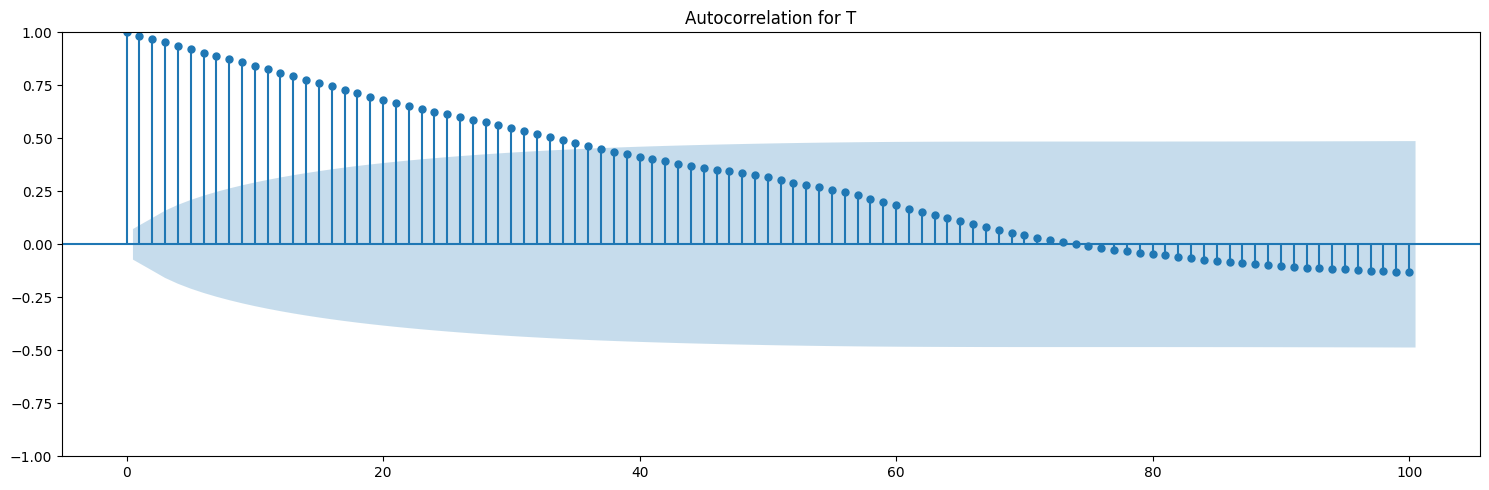

In [13]:
plot_autocorrelation(adj_close_A, title=ticker_A, lags=100)

- In the case of AT&T, the autocorrelation plot showed significant positive values for initial lags. This means that the stock's current price is positively correlated with its recent past prices.
- The fact that autocorrelation values decrease with increasing lags but remain positive indicates a momentum effect — past prices can influence future prices, with this influence diminishing over time. It suggests that the stock price has a certain level of predictability based on its recent past.

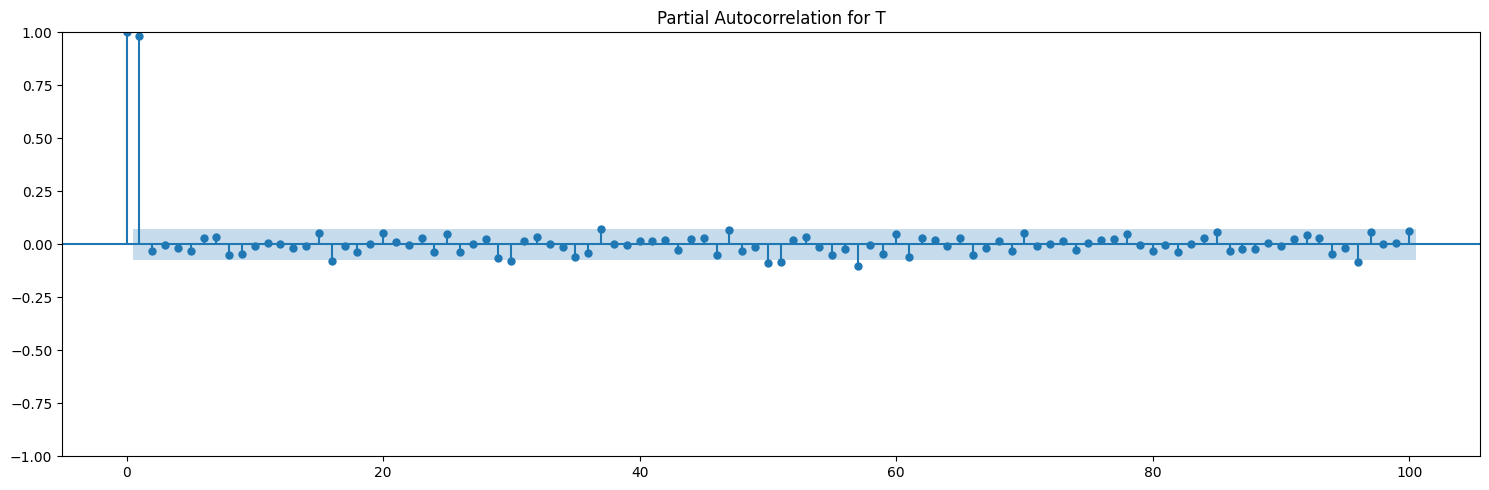

In [14]:
plot_partial_autocorrelation(adj_close_A, title=ticker_A, lags=100)

- For AT&T, significant partial autocorrelation at the initial lags and near-zero values for subsequent lags indicates that the immediate past (like the previous day) has a significant impact on the current price.
- The sharp drop in the partial autocorrelation values after the first few lags suggests that once you account for the immediate past, the further past does not provide additional predictive power. This insight is particularly useful in building predictive models, as it suggests focusing on the most recent past.

#### In summary for AT&T autocorrelations

- The correlation in daily returns would indicate how consistent the price movements are.
- The autocorrelation suggests a momentum effect where recent past prices are good indicators of near-future prices.
- The partial autocorrelation highlights the significance of the immediate past in predicting current prices, with diminishing returns on looking further back.

#### Verizon

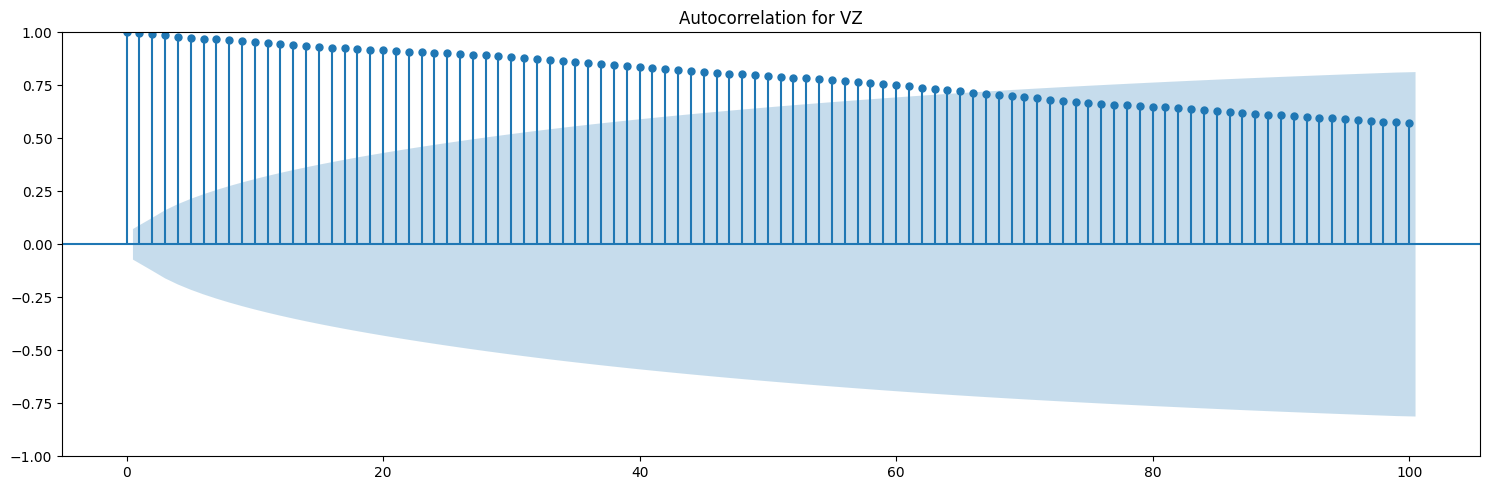

In [15]:
plot_autocorrelation(adj_close_B, title=ticker_B, lags=100)

**Verizon Autocorrelation Interpretation**:

- The autocorrelation function for Verizon showed significant positive values at initial lags, indicating a strong positive relationship between the current price and its recent past. This suggests that past prices have a considerable influence on the current price, with this influence waning as the time lag increases.
- The presence of positive autocorrelation at initial lags and its gradual decrease over time is indicative of a momentum effect. This means that the stock price movements tend to continue in their recent direction, and recent past prices can be somewhat predictive of near-future prices.

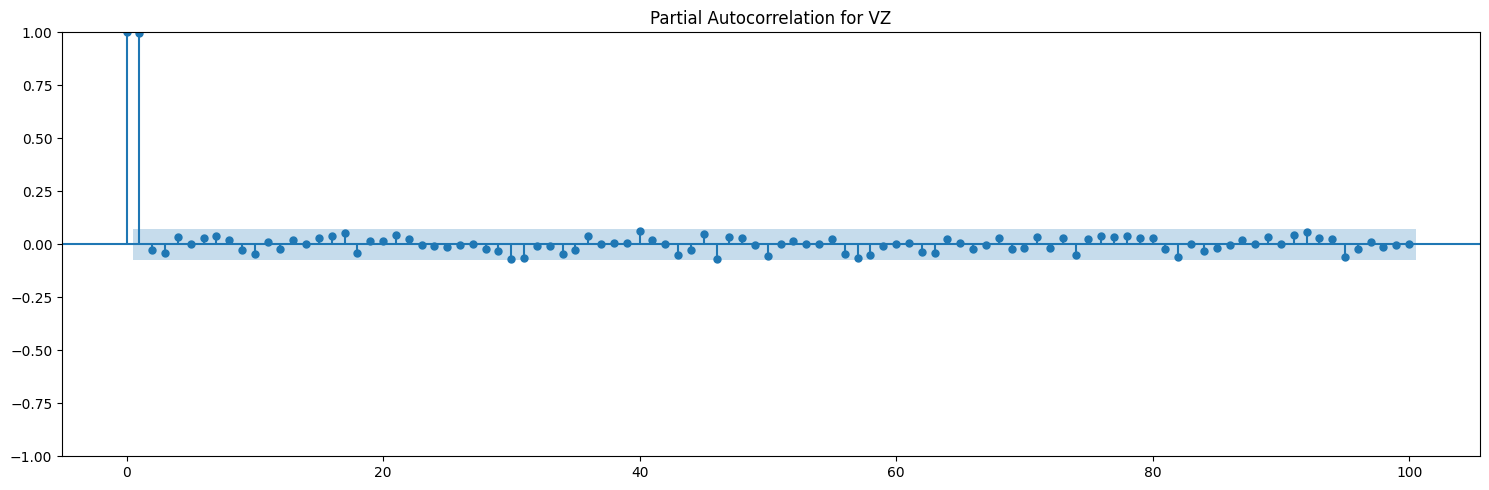

In [16]:
plot_partial_autocorrelation(adj_close_B, title=ticker_B, lags=100)

#### Partial autocorrelation
- The partial autocorrelation for Verizon, much like AT&T, showed significant values at the initial lags, dropping off sharply to near-zero for higher lags. This pattern indicates that the most recent past (like the previous day or two) has a substantial impact on the current price.
- The rapid drop in partial autocorrelation values suggests that, when controlling for the immediate past, the more distant past does not significantly affect the current price. This insight is valuable for predictive modeling, as it implies that models should primarily focus on the most recent past for predictions.

#### Summary
- The **autocorrelation** reveals a momentum effect where recent past prices can inform predictions about near-future prices, though this predictive power diminishes with time.
- The **partial autocorrelation** underscores the importance of the immediate past in influencing the current price, with little additional predictive power gained from considering more distant past prices.

Implications for portfolio optimization.

1. **Diversification and Risk Management**:
   - Correlation analysis helps in diversifying a portfolio. Similar correlation patterns between assets, like AT&T and Verizon, might lead to similar market reactions, affecting diversification.
   - Autocorrelation, indicating a momentum effect, can inform momentum trading strategies but requires caution due to potential trend reversals.

2. **Predictive Modeling and Tactical Asset Allocation**:
   - Partial autocorrelation suggests focusing on recent prices for short-term predictive models and tactical asset allocation, enhancing model efficiency and relevance.

3. **Investment Strategy**:
   - The results suggest AT&T and Verizon may be more suitable for short-term trading, given the diminishing predictability from past prices over longer periods.

4. **Risk Assessment**:
   - Strong autocorrelation can imply lower short-term investment risk, but reliance on historical patterns can underestimate true market risk.

### Stationarity

In [17]:
def test_stationarity(timeseries):
    """Perform Dickey-Fuller test and print the results."""
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(
        dftest[:4],
        index=[
            'Test Statistic',
            'p-value',
            '#Lags Used',
            'Number of Observations Used'
            ]
        )


    print(dfoutput)
    print('Critical Values:')
    for key, value in dftest[4].items():
        print(f'\t{key}: {value}')

#### AT&T

In [18]:
test_stationarity(adj_close_A)

Results of Dickey-Fuller Test:
Test Statistic                  -2.378899
p-value                          0.147781
#Lags Used                       0.000000
Number of Observations Used    736.000000
dtype: float64
Critical Values:
	1%: -3.4392661055744767
	5%: -2.86547495466493
	10%: -2.56886540295664


> The p-value is greater than 0.05 and therefore we cannot reject the null hypothesis. This means that the data is not stationary.

- **Test Statistic**: -2.378898
- **p-value**: 0.147781
- **Critical Values**: -3.439 (1%), -2.865 (5%), -2.569 (10%)

Interpretation:

- The test statistic (-2.378898) is higher than the critical values at all common significance levels (1%, 5%, and 10%). This means we fail to reject the null hypothesis at these levels.
- The p-value is 0.147781, which is higher than 0.05 (common threshold for significance). This further supports the failure to reject the null hypothesis.
- Conclusion: The AT&T stock price series is not stationary. This suggests the presence of a unit root, implying that the series may have trends or varying variance over time.

#### Verizon

In [19]:
test_stationarity(adj_close_B)

Results of Dickey-Fuller Test:
Test Statistic                  -1.402183
p-value                          0.581229
#Lags Used                       0.000000
Number of Observations Used    736.000000
dtype: float64
Critical Values:
	1%: -3.4392661055744767
	5%: -2.86547495466493
	10%: -2.56886540295664


> The p-value is greater than 0.05 and therefore we cannot reject the null hypothesis. This means that the data is not stationary.

- **Test Statistic**: -1.402183
- **p-value**: 0.581229
- **Critical Values**: -3.439 (1%), -2.865 (5%), -2.569 (10%)

Interpretation:

- The test statistic (-1.402183) is again higher than the critical values for all common significance levels. Thus, we fail to reject the null hypothesis.
- The p-value is 0.581229, significantly higher than 0.05, indicating a strong reason to retain the null hypothesis.
- Conclusion: The Verizon stock price series is not stationary, indicating trends or varying variance over time.

**Implications:**

The lack of stationarity can be due to trends, cycles, or other forms of time-dependent structure in the data. Non-stationary data often require transformation, such as differencing, to make them stationary before applying many time series forecasting methods.

The correlation between AT&T and Verizon is 0.7, which is a strong positive correlation.

### Portfolio Optimization

We will use two approaches for portfolio optimization:
1. **Convex Optimization (`cvxpy`)**: This approach uses convex optimization to minimize the portfolio variance.
2. **Minimization (`scipy.optimize`)**: This approach uses a more general-purpose optimization algorithm (Sequential Least Squares Programming, or SLSQP) to minimize the portfolio volatility.

#### Comparative and Practical Considerations:
1. **Ease of Use**:
    - The `cvxpy` approach may require more familiarity with convex optimization concepts.
    - The `scipy.optimize` approach is more straightforward and is part of a more commonly used general-purpose optimization library.
2. **Flexibility**:
    - Both methods can be adapted for more complex scenarios (e.g., adding more assets).
    - The `scipy.optimize` method might offer more flexibility for custom objective functions and constraints.
3. **Performance and Scalability**:
    - The `cvxpy` approach is generally more efficient for larger, more complex portfolio optimization problems due to its specialization in convex problems.
    - The `scipy.optimize` method, while versatile, might face performance issues or difficulties in finding the global minimum in more complex or non-convex landscapes.
4. **Suitability**:
    - **Convex Optimization (`cvxpy`)**: More suitable for large-scale, complex portfolio optimization problems where **variance minimization** is the sole objective.
    - **Minimization (`scipy.optimize`)**: Better for smaller-scale, less complex problems, or when there is a need for a more general-purpose optimization framework. More focused on **volatility minimization**.

##### Convex Optimization (cvxpy):

**Methodology**

Utilizes convex optimization, specifically designed for problems where the objective function and constraints form a convex set.
The method inherently guarantees finding the global minimum due to the nature of convex problems.

**Objective function**

Specifically focuses on minimizing the quadratic form, which represents the portfolio variance.
Highly suitable for problems where the primary goal is risk (variance) minimization.

##### Implementation description

1. **Objective**: The goal is to minimize the overall variance of the portfolio, which is a measure of risk. By doing so, we aim to find the optimal balance between the stocks that reduces the portfolio's volatility.

2. **Inputs for Optimization**:
   - **Variances $\sigma_{A,B}$**: The variances of the individual stocks (AT&T and Verizon) represent the volatility of each stock.
   - **Correlation $\rho$**: The correlation between the stocks indicates how similarly they move. A high correlation means the stocks tend to move in the same direction.



3. **Covariance**:
   - Covariance $\sigma_{A,B}$ is calculated from the individual stock variances and their correlation. It's a measure of how much the stocks move together.

4. **Optimization Variables**:
   - We will create a vector $\mathbf{x}$ representing the weights of each stock in the portfolio. These weights determine how much of each stock is held in the portfolio.

5. **Covariance Matrix**:
   - The covariance matrix $P$ is a 2x2 matrix composed of the variances and the covariance. This matrix is fundamental in calculating the portfolio variance.

6. **Quadratic Form**:
   - The portfolio variance $\sigma^2_p$) is represented by the quadratic form $\mathbf{x^T} \mathbf{P} \mathbf{x}$. This form combines the weights and the covariance matrix to compute the total variance of the portfolio.

7. **Objective Function**:
   - The objective function in our optimization problem is to minimize the portfolio variance, represented by the quadratic form.

8. **Constraints**:
   - We will set constraints to ensure the weights in vector $\mathbf{x}$ sum up to 1, meaning the total investment is distributed across the two stocks.

9. **Solving the Optimization Problem**:
   - Using these inputs and constraints, we will employ convex optimization (via `cvxpy` library) to find the optimal weights that minimize the portfolio variance.

With these steps, we'll be able to determine the proportion of investment to be allocated to each stock (AT&T and Verizon) to achieve the lowest possible risk, as measured by the portfolio's variance.
This process is a fundamental aspect of modern portfolio theory.

##### Optimization implementation (cvxpy)

In [56]:
# Optimize portfolio variance
optimal_weights_var, minimized_variance = optz.portfolio_variance(varA := adj_close_A.var(),
                            varB := adj_close_B.var(),
                            correlation := adj_close_A.corr(adj_close_B))

# Print the weights of Stock A and Stock B in the optimized portfolio as percentages
optimal_weights_var_dict = dict(zip(config["data_source_params"]["tickers"], map(round, optimal_weights_var)))

print("Optimal Weights (Variance):")
for stock, weight in optimal_weights_var_dict.items():
    print(f"\t {stock}: {weight:%}")

print(f"Minimized Portfolio Variance: {round(minimized_variance, 5)}")

Optimal Weights (Variance):
	 T: 100.000000%
	 VZ: 0.000000%
Minimized Portfolio Variance: 2.29912


#### Minimization (scipy.optimize):

**Methodology**
- Employs a more general-purpose optimization algorithm (Sequential Least Squares Programming, or SLSQP).
- Can handle a wider range of problems but does not inherently guarantee a global minimum unless the problem is convex.

**Objective function**
- Directly minimizes the portfolio volatility (standard deviation).
- While closely related to variance, focusing on standard deviation might be more intuitive in terms of risk perception.

##### Implementation

In [51]:
mean_returns = np.array([returns_A.mean(), returns_B.mean()])

# Sample mean returns and covariance matrix for volatility optimization
cov_matrix = np.array([[varA, correlation * np.sqrt(varA * varB)], 
                        [correlation * np.sqrt(varA * varB), varB]])  # Example covariance matrix

# Optimize portfolio volatility
optimal_weights_vol, minimized_volatility = optz.portfolio_volatility(mean_returns, cov_matrix)

optimal_weights_vol_dict = dict(zip(config["data_source_params"]["tickers"], map(round, optimal_weights_vol)))

print("Optimal Weights (Volatility):")
for stock, weight in optimal_weights_vol_dict.items():
    print(f"\t {stock}: {weight:%}")

print(f"Minimized Portfolio Volatility: {round(minimized_volatility, 5)}")

Optimal Weights (Volatility):
	 T: 100.000000%
	 VZ: 0.000000%
Minimized Portfolio Volatility: 1.51628


#### Interpretation

The portfolio optimization results, focusing on both variance and volatility minimization, suggest investing entirely in AT&T (T) and not in Verizon (VZ). In both cases, the optimization process indicates a 100% allocation to AT&T. This outcome suggests that, under the given model and input parameters, AT&T is perceived as a less risky or more favorable investment compared to Verizon, whether considering variance or volatility as the measure of risk.

Key Points:
- **Optimization Consistency**: Both variance and volatility optimizations yielded the same investment strategy, indicating a consistent risk profile assessment for the two stocks based on the model's inputs.
- **Minimized Risk Measures**: The minimized portfolio variance and volatility are solely attributed to AT&T, as Verizon has no weight in the optimized portfolio.
- **Lack of Diversification**: The recommendation for a 100% allocation in a single asset goes against the principle of diversification, typically a cornerstone of risk management in portfolio theory.
- **Consideration of Model Limitations**: The extremity of this recommendation suggests a need to re-evaluate the input parameters, constraints, and the model's assumptions. Real-world applicability should be carefully considered, taking into account broader market conditions and individual investment objectives and risk tolerance.

In summary, while the model suggests AT&T as the preferable investment for risk minimization, it's important to approach these results with caution and consider the broader context of portfolio management and investment strategy.

### References

- [Time Series Analysis in Python – A Comprehensive Guide with Examples](https://www.machinelearningplus.com/time-series/time-series-analysis-python/)